In [1]:
import datetime
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [5]:
def calc_fast_features(df):
    df.loc[:,'date_time'] = pd.to_datetime(df["date_time"])
    df.loc[:,'srch_ci'] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df.loc[:,'srch_co'] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    props = {}
    for prop in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        props[prop] = getattr(df["date_time"].dt, prop)
    
    carryover = [p for p in df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for prop in carryover:
        props[prop] = df[prop]
    
    date_props = ["month", "day", "dayofweek", "quarter"]
    for prop in date_props:
        props["ci_{0}".format(prop)] = getattr(df["srch_ci"].dt, prop)
        props["co_{0}".format(prop)] = getattr(df["srch_co"].dt, prop)
    props["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
    
    ret = pd.DataFrame(props)
    
#     ret = ret.join(dest_small, on="srch_destination_id", how='left', rsuffix="dest")
    ret = ret.drop("srch_destination_id", axis=1)
    return ret

df = calc_fast_features(train)
df.fillna(-1, inplace=True)

In [26]:
train['date_time']=pd.to_datetime(train['date_time'],infer_datetime_format = True,errors='coerce')
train['srch_ci']=pd.to_datetime(train['srch_ci'],infer_datetime_format = True,errors='coerce')
train['srch_co']=pd.to_datetime(train['srch_co'],infer_datetime_format = True,errors='coerce')

train['month']= train['date_time'].dt.month
train['duration']=((train['srch_co']-train['srch_ci'])/np.timedelta64(1,'D')).astype(float)

In [27]:
train.columns

Index([u'date_time', u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city',
       u'orig_destination_distance', u'user_id', u'is_mobile', u'is_package',
       u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'srch_destination_type_id', u'is_booking', u'cnt', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'hotel_cluster', u'month',
       u'duration'],
      dtype='object')

In [28]:
test_corr = test.corr()

In [32]:
train_corr = train.corr()

In [18]:
train.isnull().sum(axis=0)

date_time                           0
site_name                           0
posa_continent                      0
user_location_country               0
user_location_region                0
user_location_city                  0
orig_destination_distance    13525001
user_id                             0
is_mobile                           0
is_package                          0
channel                             0
srch_ci                         47089
srch_co                         47090
srch_adults_cnt                     0
srch_children_cnt                   0
srch_rm_cnt                         0
srch_destination_id                 0
srch_destination_type_id            0
is_booking                          0
cnt                                 0
hotel_continent                     0
hotel_country                       0
hotel_market                        0
hotel_cluster                       0
dtype: int64

# __FEATURE MAP CORRELATION__

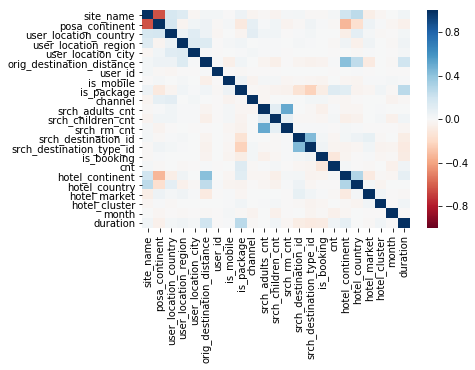

In [34]:
seaborn.heatmap(train_corr, 
                xticklabels=train_corr.columns.values, 
                yticklabels=train_corr.columns.values, 
                cmap="RdBu", 
                vmin=-1, 
                vmax=1)


In [35]:
train_corr

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,month,duration
site_name,1.000000,-0.634817,0.166413,0.128214,-0.016054,0.030325,0.024071,-0.007104,0.051813,-0.029738,...,0.029020,-0.010693,-0.010379,0.020028,0.202756,0.261031,-0.067097,-0.022408,0.006501,0.033277
posa_continent,-0.634817,1.000000,0.175936,-0.028502,0.038822,0.048051,-0.011156,0.016299,-0.094097,0.092033,...,-0.012436,0.042590,0.009724,-0.014848,-0.333605,-0.156398,0.050571,0.014938,-0.021220,-0.051796
user_location_country,0.166413,0.175936,1.000000,0.055364,0.123495,0.047720,-0.022941,0.003611,-0.025321,0.106040,...,0.009075,0.030556,0.007526,0.002761,-0.067253,0.094649,0.018212,-0.010477,-0.005040,0.025285
user_location_region,0.128214,-0.028502,0.055364,1.000000,0.129756,0.139158,-0.001498,0.016680,0.038059,0.000603,...,0.022110,0.009860,0.006352,-0.008889,0.045929,-0.054500,0.044987,0.007453,-0.012075,0.043425
user_location_city,-0.016054,0.038822,0.123495,0.129756,1.000000,0.012780,-0.006873,0.001440,0.013865,0.026494,...,0.002159,0.000508,0.002228,-0.001201,0.005356,-0.009396,0.009446,0.000831,-0.004326,0.017668
orig_destination_distance,0.030325,0.048051,0.047720,0.139158,0.012780,1.000000,0.015502,-0.054953,0.038864,0.002951,...,-0.027327,-0.039255,-0.037732,0.009996,0.414828,0.254987,-0.087682,0.007260,-0.014217,0.199183
user_id,0.024071,-0.011156,-0.022941,-0.001498,-0.006873,0.015502,1.000000,-0.005750,-0.011896,-0.002041,...,0.003012,0.004549,0.001820,-0.000380,0.003775,0.009496,-0.004097,0.001052,-0.004560,-0.001476
is_mobile,-0.007104,0.016299,0.003611,0.016680,0.001440,-0.054953,-0.005750,1.000000,0.054178,-0.032639,...,-0.008081,-0.017931,-0.030754,0.004940,-0.021121,-0.025718,0.007820,0.008412,0.019407,0.011420
is_package,0.051813,-0.094097,-0.025321,0.038059,0.013865,0.038864,-0.011896,0.054178,1.000000,-0.010251,...,-0.147546,-0.228205,-0.076347,0.126929,0.111826,-0.038909,-0.015780,0.038733,-0.009579,0.267355
channel,-0.029738,0.092033,0.106040,0.000603,0.026494,0.002951,-0.002041,-0.032639,-0.010251,1.000000,...,0.001719,0.027147,0.024438,-0.011980,-0.021297,-0.001918,0.005026,0.000707,-0.033902,-0.014359


# __HOTEL CLUSTER FREQUENCY__

In [9]:
# train.head(5)

In [37]:
train['year']= train['date_time'].dt.year
train2 = train.query('year==2013 | (year==2014 & month < 8)')

In [38]:
hotel_clusters = train2['hotel_cluster']
# hotel_clusters

In [11]:
train2['hotel_cluster'].value_counts()

91    1043720
41     772743
48     754033
64     704734
65     670960
5      620194
98     589178
59     570291
42     551605
21     550092
70     545572
18     545284
83     534132
46     534038
25     530591
62     518809
95     509266
28     507016
68     503797
82     503755
37     496061
50     489892
30     489287
9      488328
58     483253
97     479446
16     477868
72     457463
1      452694
99     444887
       ...   
19     282893
84     278264
66     273505
38     269246
87     260398
23     259233
12     259022
31     257587
67     255946
43     253578
7      252447
54     250745
92     244343
89     243560
45     241408
49     240124
3      225250
80     220218
60     217919
71     216054
93     214293
86     209054
14     192299
75     165226
24     164127
35     139122
53     134812
88     107784
27     105040
74      48355
Name: hotel_cluster, Length: 100, dtype: int64

In [39]:
x_pos = np.arange(100)
performance = train2['hotel_cluster'].value_counts().sort_index()


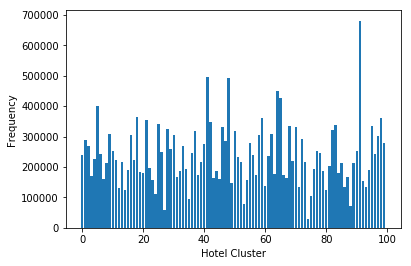

In [40]:
plt.bar(x_pos, performance)
plt.xlabel('Hotel Cluster')
plt.ylabel('Frequency')
 
plt.show()

# __RELATIVE FEATURE IMPORTANCE__

In [21]:
train["date_time"] = pd.to_datetime(train["date_time"])
train["year"] = train["date_time"].dt.year
train["month"] = train["date_time"].dt.month

train['srch_ci']=pd.to_datetime(train['srch_ci'],infer_datetime_format = True,errors='coerce')
train['srch_co']=pd.to_datetime(train['srch_co'],infer_datetime_format = True,errors='coerce')
train['duration']=(train['srch_co']-train['srch_ci']).astype('timedelta64[h]')
train = train.query('is_booking==True & year==2014')

In [22]:
# Feature Importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

y=train['hotel_cluster']
X=train.drop(['hotel_cluster','is_booking', 'date_time', 'srch_co', 'srch_ci'],axis=1) # in training dataset, have clicking and booking event


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
X_train.columns

Index([u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city',
       u'orig_destination_distance', u'user_id', u'is_mobile', u'is_package',
       u'channel', u'srch_adults_cnt', u'srch_children_cnt', u'srch_rm_cnt',
       u'srch_destination_id', u'srch_destination_type_id', u'cnt',
       u'hotel_continent', u'hotel_country', u'hotel_market', u'year',
       u'month', u'duration'],
      dtype='object')

In [27]:
m=X_train.orig_destination_distance.mean()
X_train.orig_destination_distance.fillna(m, inplace=True)

/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [28]:
rf_tree = RandomForestClassifier(n_estimators=31,max_depth=10,random_state=123)
rf_tree.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=31, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [29]:
importance = rf_tree.feature_importances_
indices=np.argsort(importance)[::-1][:10]

In [30]:
importance[indices]

array([ 0.23520075,  0.16915829,  0.16608842,  0.16284408,  0.05737025,
        0.03330955,  0.03093724,  0.02998858,  0.02460436,  0.02106831])

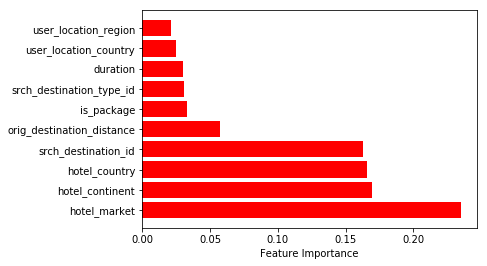

In [31]:
plt.barh(range(10), importance[indices],color='r')
plt.yticks(range(10),X_train.columns[indices])
plt.xlabel('Feature Importance')
plt.show()

In [ ]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
# display the relative importance of each attribute
# print(model.feature_importances_)

In [ ]:
importance = model.feature_importances_
indices=np.argsort(importance)[::-1][:10]

In [ ]:
plt.barh(range(10), importance[indices],color='r')
plt.yticks(range(10),X_train.columns[indices])
plt.xlabel('Feature Importance')
plt.show()